# 3 Simulations des trajectoires des sondes spatiales

Dans cette partie, on va commencer à simuler les trajectoires des sondes spatiales. les fichiers Python utilisées dans cette partie vont être dans le dossier **New Horizons**.

## 3.1 Interpolation des trajectoires des planètes:

Afin de simuler la trajectoire d'une sonde spatiale, on doit avoir accès aux trajectoires des planètes à chaque instant, surtout puisqu'on aura besoin d'adapter le pas d'intégration de la sonde, mais jusqu'à l'instant on a juste intégré les trajectoires des planètes avec un pas constant, donc pour remédier à ce problème, on peut faire une intérpolation des trajectoires des planètes, pour pouvoir y accéder à chaque instant.

Pour implémenter cette interpolation, on propose d'utiliser la fonction **UnivariateSpline** du module **scipy.interpolate**, mais afin de simplier la tâche, on propose de faire les modifications suivantes sur la classe **objet**.

### 3.1.1 Modification de la classe objet:

La fonction **UnivariateSpline** rend comme output une fonction qui va prendre comme argument l'instant actuelle, donc on propose d'ajouter 3 attributs **x_interpol**, **y_interpol** et **z_interpol** qui vont être des fonctions qui donneront les positions **x,y** et **z** à un instant donné en argument, alors la nouvelle classe va s'écrire de cette manière.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class objet:
	""" Classe représentant les objets qui influence par la gravitation
		Attributs:
		nom 
		masse: Kg
		position (x, y, z): au
		vitesse (v_x, v_y, v_z) : au/day
	"""

	nom = "objet"
	masse = None
	x0 = 0
	y0 = 0
	z0 = 0
	vx0 = 0
	vy0 = 0
	vz0 = 0
	#Listes des positions et vitesse 
	x = None 
	y = None
	z = None
	vx = None
	vy = None 
	vz = None

	#Fonctions interpolees qui contient les coordonnees
	x_interpol = None
	y_interpol = None
	z_interpol = None

	def __init__(self, nom = "objet", masse = None, x0 = 0, y0 = 0, z0 = 0, vx0 = 0, vy0 = 0, vz0 = 0):
		"""Constructeur de notre classe"""
		self.nom = nom
		self.masse = masse
		self.x0 = x0
		self.y0 = y0
		self.z0 = z0
		self.vx0 = vx0
		self.vy0 = vy0
		self.vz0 = vz0

### 3.1.2 Implémentation des trajectoires des planètes:

Dans cette partie, on va juste refaire l'intégration des trajectoires non couplées pour les interpoler afin de les rendre exploitable dans l'intégration des trajectoires des sondes spatiales.

**Redéfinition des variables globales et des fonctions auxiliaires:**

In [2]:
au = 1.49597870e11 #Unité astronomique
jour = 24*3600 #Un jour

G = 6.67408e-11 #Constante gravitationelle 

In [3]:
#Definition de fonction fx(M,x,y,z) et fy(M,x,y,z)
def fx(M,x,y,z):
	"""
	Retourne l'acceleration gravitationnelle suivant x dû à un objet de masse M distants de l'objet étudié de x**2+y**2+z**2
	"""
	return -((G*M)/(x**2+y**2+z**2)**(3/2))*x*(jour**2/au**3)

def fy(M,x,y,z):
	"""
	Retourne l'acceleration gravitationnelle suivant y dû à un objet de masse M distants de l'objet étudié de x**2+y**2+z**2
	"""
	return -((G*M)/(x**2+y**2+z**2)**(3/2))*y*(jour**2/au**3)

def fz(M,x,y,z):
	"""
	Retourne l'acceleration gravitationnelle suivant z dû à un objet de masse M distants de l'objet étudié de x**2+y**2+z**2
	"""
	return -((G*M)/(x**2+y**2+z**2)**(3/2))*z*(jour**2/au**3)

def E(M, x, y, z, vx, vy, vz):
	"""
	Calculer l'energie massique d'un objet sous effet d'un seul objet de masse M
	"""
	return 0.5*(vx**2+vy**2+vz**2)*(au**2/jour**2)-(G*M)/(np.sqrt(x**2+y**2+z**2)*au)
E = np.vectorize(E) #Vectoriser une fonction est benefique en terme de performance et memoire

def pot(M, x, y, z):
	"""
	Retourne le potentiel massique d'un objet par rapport à un autre objet de masse M et distant de x**2+y**2+z**2
	"""
	return -(G*M)/(np.sqrt(x**2+y**2+z**2)*au)

pot = np.vectorize(pot)

**Acceleration sous l'effet de soleil seulement :**

In [4]:
def acceleration_sol(bodies, i, j): #avec effet de soleil seulement
	"""
	Calculer l'acceleration relative à un objet bodies[i]
	bodies: tous les objets
	i: indice de l'objet concerne qui subit la gravitation du soleil seulement
	j: indice de pas
	"""

	ax = fx(bodies[0].masse, bodies[i].x[j], bodies[i].y[j], bodies[i].z[j])
	ay = fy(bodies[0].masse, bodies[i].x[j], bodies[i].y[j], bodies[i].z[j])
	az = fz(bodies[0].masse, bodies[i].x[j], bodies[i].y[j], bodies[i].z[j])

	return (ax, ay, az)

**Conditions Initiales:**

Pour les conditions initiales, on va plûtot intégrer les planètes avec des conditions initiales qui correspondent à la date de lancement de la sonde spatiale New Horizons, de même, ces conditions initiales sont récupérés ici : http://vo.imcce.fr/webservices/miriade/?forms

On proposer de faire cette implémentation dans un autre dossier **New_Horizons**

**Importation des données:**

In [5]:
import os
os.chdir("/home/mh541/Desktop/Projet_Numerique/New_Horizons") #Changer le repertoire de travail (a remplacer 'mh541' par le nom de user)

data = np.genfromtxt("initial_conditions_solarsystem.txt", usecols=(1,2,3,4,5,6,7), skip_header=1) #On ne peut pas importer du texte avec genfromtxt à cause de problème d'encodage
names = np.loadtxt("names_solarsystem.txt", dtype = str, skiprows=1, usecols=(1,)) #Importation de texte (nomes des objets dans le systeme solaire)

**Rénitialisation des données :**

In [6]:
bodies = np.array([objet() for i in range(10)])  #Creation d'une liste des objets (on a au total 9 objets: soleil et 9 planetes)

Nbr_obj = len(bodies) #Definition de nombres d'objets

#Definition des parametres de chaque objet
for i in range(Nbr_obj):
	bodies[i].nom = names[i][2:-1] # [2:-1] pour supprimer les caracteres indesires
	bodies[i].masse = data[i][0]
	bodies[i].x0 = data[i][1]
	bodies[i].y0 = data[i][2]
	bodies[i].z0 = data[i][3] 
	bodies[i].vx0 = data[i][4]
	bodies[i].vy0 = data[i][5]
	bodies[i].vz0 = data[i][6]

**Implémentation:**

Le vol de New Horizons dans l'espace dure un peu près **10 ans**, donc on va intégrer les planètes sur cette période avec le schéma de Verlet.

Pour ne pas réecrire le même code d'implémentation après, on va créer la fonction **implementation_trajs** qui va s'occuper de ça.

In [7]:
#Definition de pas de temps
dt = 1 #step
T = int(365/dt)*10 # (Nombre de steps)<-> Periode d'integration T = int(365/dt)* nbr ans

#begin Function --------------------------------------------------------------------------------
def implementation_trajs(bodies, dt, T):
	#Intialisation des attributs x,y,z,vx,vy,vz de chaque objet bodies[i]
	for i in range(Nbr_obj):
		bodies[i].x = np.zeros(T); bodies[i].x[0] = bodies[i].x0
		bodies[i].y = np.zeros(T); bodies[i].y[0] = bodies[i].y0
		bodies[i].z = np.zeros(T); bodies[i].z[0] = bodies[i].z0

		bodies[i].vx = np.zeros(T); bodies[i].vx[0] = bodies[i].vx0
		bodies[i].vy = np.zeros(T); bodies[i].vy[0] = bodies[i].vy0
		bodies[i].vz = np.zeros(T); bodies[i].vz[0] = bodies[i].vz0

	#Definitions des v_demi.
	vx_demi = np.zeros(Nbr_obj)
	vy_demi = np.zeros(Nbr_obj)
	vz_demi = np.zeros(Nbr_obj)

	#Implementation de l'integrateur de Verlet pour chaque objet (sauf le soleil)
	for j in range(T-1): 

	    #Phase 1: Calcul de vitesses milieu et affectation des position a l'intant j+1
		for i in range(1,Nbr_obj): #Modification des parametres pour chaque objet a l' instant j

			#Récupération de l'acceleration
			fx_j, fy_j, fz_j = acceleration_sol(bodies, i, j) #L'acceleration au pas j relative à l'objet i

			#Definition des variables de milieux
			vx_demi[i] = bodies[i].vx[j] + (dt/2)*fx_j
			vy_demi[i] = bodies[i].vy[j] + (dt/2)*fy_j
			vz_demi[i] = bodies[i].vz[j] + (dt/2)*fz_j

			# Affectation des positions à l'indice i+1
			bodies[i].x[j+1] = bodies[i].x[j] + dt*vx_demi[i]
			bodies[i].y[j+1] = bodies[i].y[j] + dt*vy_demi[i]
			bodies[i].z[j+1] = bodies[i].z[j] + dt*vz_demi[i]

	    #Phase 2: Affectation des vitesse a l'instant j+1   
		for i in range(1,Nbr_obj):

			#L'acceleration au pas i+1 relative à l'objet j
			fx_jplus1, fy_jplus1, fz_jplus1 = acceleration_sol(bodies, i, j+1) #Il faut faire cette étape après le calcul de postion à l'indice i+1

	        # Affectation des vitesses à l'indice j+1
			bodies[i].vx[j+1] = vx_demi[i] + (dt/2)*fx_jplus1
			bodies[i].vy[j+1] = vy_demi[i] + (dt/2)*fy_jplus1
			bodies[i].vz[j+1] = vz_demi[i] + (dt/2)*fz_jplus1

#[End]----------------------------------------------------------------------------------------------------

implementation_trajs(bodies, dt, T) #Application de la fonction

### 3.1.3 Interpolation des trajectoires:

Maintenant, comme on a calculé les trajectoires des planètes sur un pas constant **dt**, on peut procéder vers l'interpolation avec la fonction **UnvariantSpline**.

In [8]:
from scipy.interpolate import UnivariateSpline

for i in range(Nbr_obj):

	t = np.linspace(1,T,T)*dt #Def des intervalles

	bodies[i].x_interpol = UnivariateSpline(t, bodies[i].x, s=0)
	bodies[i].y_interpol = UnivariateSpline(t, bodies[i].y, s=0)
	bodies[i].z_interpol = UnivariateSpline(t, bodies[i].z, s=0)

Maintenant, on peut faire un plot des trajectoires interpolées et intégrées.

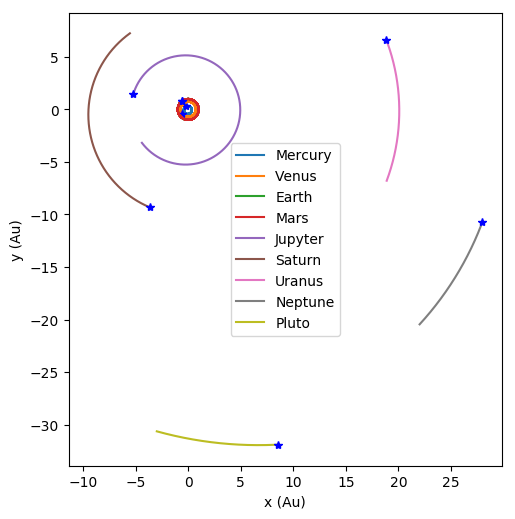

In [9]:
#Definition de figure
fig=plt.figure(figsize=(9, 6), dpi= 100, facecolor='w', edgecolor='k') #To modify the size of the figure
ax = fig.add_subplot(111) #definition de l'axe    
    
#Plot des traj interpolees
for i in range(1,Nbr_obj):	
	ax.plot(bodies[i].x_interpol(t), bodies[i].y_interpol(t), label = bodies[i].nom) 
	ax.plot(bodies[i].x[-1], bodies[i].y[-1], "b*")

plt.gca().set_aspect('equal', adjustable='box') #equal ratios of x and y

ax.set_xlabel("x (Au)")    
ax.set_ylabel("y (Au)")
    
plt.legend()    
plt.show()

## 3.2 New Horizons:

Comme première application des résultats précédents, On va essayer de simuler la trajectoire de la sonde spatiale New Horizons qui est lancée le 19 janvier 2006, et qui s'est approchée de Pluto et de ses satellites de Janvier 2015 à Octobre 2016. Le but ici serait de s'approcher le plus possible la trajectoire de la sonde.

Pendant le voyage vers Pluto, la sonde va passer par Jupiter afin d'augmenter sa vitesse et il va changer sa direction par effet de fronde gravitationnelle.

Mais afin de garantir une meilleure précision de la trajectoire, il faut adapter le pas d'intégration selon l'intensité de l'accéleration gravitationnelle, en d'autres termes, le pas de temps doit diminuer de moins en moins si la sonde sent une force de plus en plus grande, et vice versa, donc on va gagner en termes de précision et de rapidité si on est loin des planètes.

PS: les fichiers relatives à cette sous-section seront dans le dossier **New_Horizons**.

### 3.2.1 Schéma de Verlet Adaptatif:

Il se trouve que l'adaptation de pas peut nuire au caractère symplectique de schéma de Verlet, Voir ici 
(**The Adaptive Verlet Method, W.HUANG & B.LEIMKUHLER, SIAM, Vol.18, pp-239-256, January 1997**).

Donc on se propose d'intégrer la trajectoire de la sonde spatiale avec un schéma de Verlet adaptatif et qui reste symplectique.

#### 3.2.1.1 Paramétrisation:

Afin de faire l'adaptation de pas, on introduit un paramètre **ds** libre tel que:

$$ dt = \frac{ds}{R(\vec{X})} $$

avec $R(\vec{X})$ une fonction (configurateur de pas) qui devient de plus en plus grande si l'accélération gravitationnelle est de plus en plus importante, donc comme première essai on peut prendre $R(\vec{X})$ relative à un objet $i$ comme:

$$R(\vec{X}) = -G\sum_{j = 0 ; \ j \neq i}^{9} \frac{M_j}{||\vec{X_i}-\vec{X_j}||}$$

Avec: 

* Objet 0: Soleil
* Objet $j$ tel que $j \ \in \ [|1,9|]$: les planètes de système solaire de Mercure à Neptune et la planète naine Pluto.


**Limitation de $R(\vec{X})$**

Afin d'éviter des grandes valeurs de $R$ (et donc des petits pas) près des planètes ou des petites valeurs de $R$ qui peuvent exploser l'intégration et donner des résultats inconsistants, on doit borner les valeurs prises par $R$, donc on se propose d'utiliser la normalisation dans l'article de ** W.HUANG & B.LEIMKUHLER** page **244**:

$$ R(u) = \frac{\sqrt{||f(u)||²+m²}}{\frac{1}{M}\sqrt{||f(u)||²+m²}+1} 
$$

Alors pour $0<m \ll M$, on aura:

$$ m \le R(u) \le M $$


#### 3.2.1.2 Schéma de Verlet adaptatif explicite:

Dans **Error Control and Adaptivity in Scientific Computing, H.Bulgak,C.Zenger, pp-200-201**, on propose un schéma adaptatif symplectique et réversible qui est relativement simple à implémenter, le schéma est le suivant:

$$ \vec{X}_{i+1/2} = \vec{X}_{i} + \frac{\Delta s}{2 \rho_i} \vec{V}_{i} $$
$$ \vec{V}_{i+1/2} = \vec{V}_{i} + \frac{\Delta s}{2 \rho_i} \vec{F}(\vec{X}_{i+1/2}) $$

$$\rho_i + \rho_{i+1} = 2 R(\vec{X}_{i+1/2}) $$

$$ \vec{V}_{i+1} = \vec{V}_{i+1/2} + \frac{\Delta s}{2 \rho_{i+1}} \vec{F}(\vec{X}_{i+1/2})  $$
$$ \vec{X}_{i+1} = \vec{X}_{i+1/2} + \frac{\Delta s}{2 \rho_{i+1}} \vec{V}_{i+1} $$

**Temps:**
$$ t_{i+1} = t_{i} + \frac{\Delta s}{2} \bigg (  \frac{1}{\rho_i} + \frac{1}{\rho_{i+1}} \bigg ) $$

avec $\rho_0$ prise égale à $R(\vec{X}_0)$ et $\vec{V}_{i+1/2}$, $\vec{X}_{i+1/2}$ les variables intermédiaires aux milieux.

#### 3.2.1.3 Implémentation de $R$:

Pour implémenter ce schéma adaptatif, il vaut mieux créer une fonction **rho_obj** qui retourne la valeur de $R(\vec{X})$.

Donc on peut écrire:

In [10]:
def rho(M, x, y, z, vx, vy, vz):
	""" 
	Retourne Le configurateur de pas pour tenir compte de l'effet d'un seule objet
	"""
	return (G*M)/((x**2+y**2+z**2)*(au**2))


def rho_obj(bodies, obj, j, t):
	"""
	Calculer le configurateur de pas rho total
	bodies: tous les objets
	obj: the concerned body which undergoes the gravitation of other objects.
	j: index of the step
	t: temps
	"""
	N = len(bodies)

	rho1 = 0 #pas le meme nom que la fonction rho

	for ip in range(N):
		#Chaque objet bodies[ip]
		rho1 = rho1 + rho(bodies[ip].masse, obj.x[j]-bodies[ip].x_interpol(t), obj.y[j]-bodies[ip].y_interpol(t), obj.z[j]-bodies[ip].z_interpol(t), obj.vx[j], obj.vy[j], obj.vz[j])

	# return rho1 mais normalisee
	return np.sqrt(rho1**2+0.0001**2)/(np.sqrt(rho1**2+0.0001**2)+1)

Pour la limitation de $R$, on prend comme valeur minimale $0.0001$ et comme valeur maximal $1$, donc par conséquent si on prend le pas $ds = 0.0001$, notre pas de temps $dt$ peut varier entre $0.0001$ jour et $1$ jour.

Le choix de **ds** reste purement expériemental, en fait, il faut l'adapter de telle façon à avoir la meilleur adaptation possible des pas **dt** en un temps raisonnable.

### 3.2.2 Implémentation de la Trajectoire de New Horizons:

Dans cette sous-partie, on va essayer d'implémenter pour la première fois, la trajectoire de la sonde spatiale New Horizons en utilisant le schéma adaptatif de Verlet, et en exploitant les trajectoires interpolées précédemment.

Alors, pour commencer les calculs, il nous faut d'abord les données initiales prises ici https://ssd.jpl.nasa.gov/horizons.cgi avec la date de début: 20/01/2006:


In [11]:
sonde = objet("New Horizons", 478,-4.886893778728491E-01,  8.540814037081539E-01,  1.377446004041602E-05, -2.155158733368952E-02, -1.228948289664512E-02,  3.737717394886807E-04)

Après, on va définir le pas paramétrique **ds**, la période d'intégration **T**, et on va rénitialiser les attributs de la sonde.

Le problème qu'on va avoir ici est le suivant: puisque le pas de temps va varier, on ne sait pas la taille des tableaux qu'il faut allower dans la mémoire, alors on propose de rénitialiser les attributs par des tableaux de taille 1, et après à chaque itération, on va utiliser **append** pour ajouter des éléments dans les tableaux, mais ceci n'est pas optimal en termes d'espace utilisation mémoire!!!

In [12]:
ds = 0.0001 #step parametrique
T = 365*9+200 #(Nombre de steps)<->Periode d'integration

#Definition des tableaux 
sonde.x = np.zeros(1); sonde.x[0] = sonde.x0
sonde.y = np.zeros(1); sonde.y[0] = sonde.y0
sonde.z = np.zeros(1); sonde.z[0] = sonde.z0

sonde.vx = np.zeros(1); sonde.vx[0] = sonde.vx0 
sonde.vy = np.zeros(1); sonde.vy[0] = sonde.vy0 
sonde.vz = np.zeros(1); sonde.vz[0] = sonde.vz0

#Definition d'un tableau qui va contenir le temps (ici le pas n'est pas constant, donc on est oblige de faire ca)
#Time array
time = np.zeros(1) 

#Def des v_demi et x_demi pour l'objet
vx_demi = 0
vy_demi = 0
vz_demi = 0

x_demi = 0
y_demi = 0
z_demi = 0

Afin de calculer l'accéleration gravitationnelle appliquée sur la sonde spatiale à chaque instant, on propose de créer une fonction ** acceleration_interpol** qui va exploiter les trajectoires interpolées: 

In [13]:
def acceleration_interpol(bodies, t, x, y, z):
	"""
	Calculer l'acceleration relative a la sonde de coord x,y,z a l'instant t
	Les coord des objets sont stockes dans la methode x/y/z_interpol qui prend comme parametre un instant donne
	"""

	N = len(bodies)

	ax = 0; ay = 0; az = 0 #L'acceleration

	for ip in range(N):
		#Chaque objet bodies[ip] applique une force de gravitation sur l'objet object() 

		ax += fx(bodies[ip].masse, x-bodies[ip].x_interpol(t), y-bodies[ip].y_interpol(t), z-bodies[ip].z_interpol(t))
		ay += fy(bodies[ip].masse, x-bodies[ip].x_interpol(t), y-bodies[ip].y_interpol(t), z-bodies[ip].z_interpol(t))
		az += fz(bodies[ip].masse, x-bodies[ip].x_interpol(t), y-bodies[ip].y_interpol(t), z-bodies[ip].z_interpol(t))

	return (ax, ay, az)

Maintenant, on a tous qu'il faut pour établir le schéma intégrateur adaptatif de Verlet, alors ici, il faut juste appliquer le schéma proposé dans la section 3.2.1.2.

**Implementation dans simulation_traj_sonde_adaptive_verlet.py**

In [14]:
#Implementation de l'integrateur de Verlet

i = 0 #Parametre d'itération

rho1 = rho_obj(bodies, sonde, 0, time[0])

while time[i] < T:

#Define Rho 1 -> rho[i]
	if i>0:
		rho1 = rho2

#Definition des variables de milieux

	x_demi = sonde.x[i] + (ds/(2*rho1))*sonde.vx[i]
	y_demi = sonde.y[i] + (ds/(2*rho1))*sonde.vy[i]
	z_demi = sonde.z[i] + (ds/(2*rho1))*sonde.vz[i]

	fx1, fy1, fz1 = acceleration_interpol(bodies, time[i], x_demi, y_demi, z_demi)

	vx_demi = sonde.vx[i] + (ds/(2*rho1))*fx1
	vy_demi = sonde.vy[i] + (ds/(2*rho1))*fy1
	vz_demi = sonde.vz[i] + (ds/(2*rho1))*fz1

#Define Rho 2 -> rho[i+1]
	rho2 = 2*rho_obj(bodies, sonde, i, time[i]) - rho1

	# Affectation des positions à l'indice i+1
	sonde.vx = np.append(sonde.vx , vx_demi + (ds/(2*rho2))*fx1)
	sonde.vy = np.append(sonde.vy , vy_demi + (ds/(2*rho2))*fy1)
	sonde.vz = np.append(sonde.vz , vz_demi + (ds/(2*rho2))*fz1)

	sonde.x = np.append(sonde.x , x_demi + (ds/(2*rho2))*sonde.vx[i+1])
	sonde.y = np.append(sonde.y , y_demi + (ds/(2*rho2))*sonde.vy[i+1])
	sonde.z = np.append(sonde.z , z_demi + (ds/(2*rho2))*sonde.vz[i+1])

	# Affectation de temps
	
	time = np.append(time, time[i]+((ds/2)*(1/rho1 + 1/rho2)))

#incrementation
	i = i+1

Avec cette implémentation, on peut faire le plot de la trajectoire de la sonde (dans la plan (x,y)), ceci va permettre de comparer la trajectoire simulée avec la trajectoire réelle.

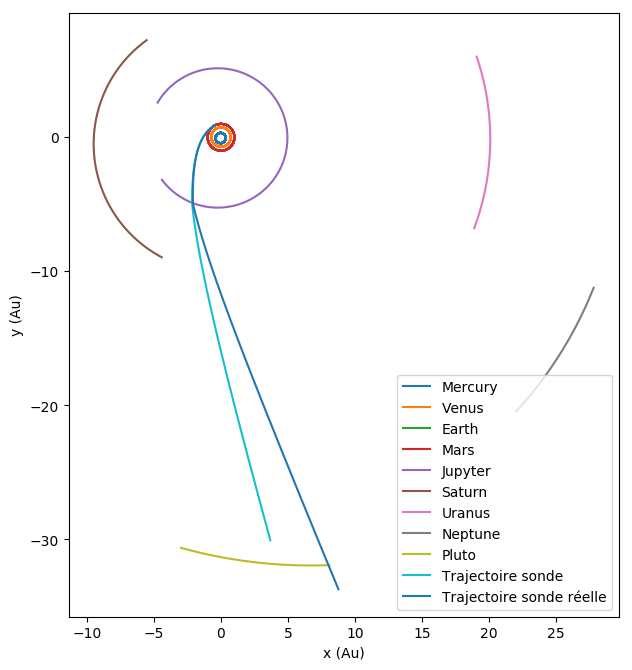

In [15]:
#Definition de figure
fig=plt.figure(figsize=(11, 8), dpi= 100, facecolor='w', edgecolor='k') #To modify the size of the figure
ax = fig.add_subplot(111) #definition de l'axe    
    
t = np.linspace(1,T,T)*dt #Def des intervalles
    
#Plot des traj interpolees
for i in range(1,Nbr_obj):	
	ax.plot(bodies[i].x_interpol(t), bodies[i].y_interpol(t), label = bodies[i].nom) 

#plot traj de la sonde
ax.plot(sonde.x, sonde.y, label="Trajectoire sonde")

#Plot traj reelle de la sonde (les donnees sont stockes dans horizons_results.txt)
x, y, z = np.genfromtxt("horizons_results.txt", usecols=(2,3,4), unpack=True, delimiter = ",") 
ax.plot(x, y, label = "Trajectoire sonde réelle")
    
plt.gca().set_aspect('equal', adjustable='box') #equal ratios of x and y
 
ax.set_xlabel("x (Au)")    
ax.set_ylabel("y (Au)")    

plt.legend()    
plt.show()

Comme on remarque sur le plot, la trajectoire  de la sonde simulée est déviée de la trajectoire réelle juste après l'effet de fronde gravitationelle dû à Jupyter, donc la première chose à vérifier pour déterminer la source d'erreur est l'adaptation de pas.

**Vérification de l'adaptation de pas:**

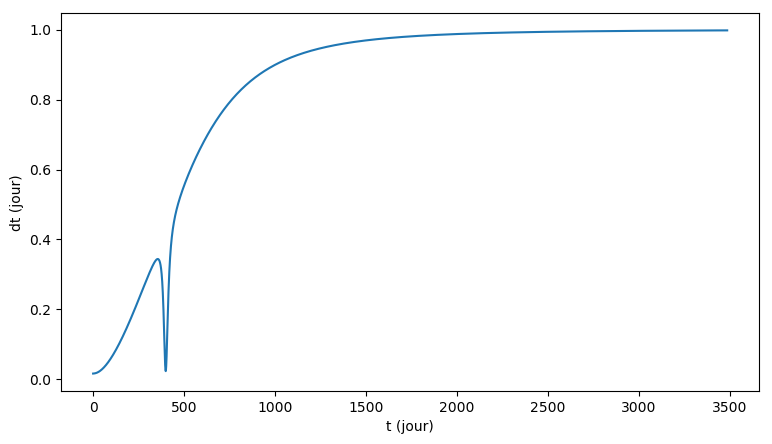

In [16]:
#Definition de figure
fig=plt.figure(figsize=(9, 5), dpi= 100, facecolor='w', edgecolor='k') #To modify the size of the figure
ax = fig.add_subplot(111) #definition de l'axe  

ax.plot(time[1:], np.diff(time))

ax.set_xlabel("t (jour)")    
ax.set_ylabel("dt (jour)")

plt.show()

On vérifie bien là que le schéma adaptatif est sensible aux effets gravitationnels, en plus, loin de planètes le pas va augmenter de telle façon à rendre les calculs plus rapides, et comme mentionné avant, on a limité le paramètre **$R$** avant de telle façon que **$dt$** ne dépasse pas le $1$ jour, car sinon, le pas va augmenter jusqu'à la limite "threshold" du schéma d'intégration, et par conséquent le schéma ne va plus fonctionner si on dépasse cette limite.

**Source d'erreur:**

Après beaucoup de travail de débugage, on a trouvé que le problème est tellement sensible aux conditions initiales des planètes, pour illustrer ce propos, on a essayé de modifier les conditions initiales (qui seront dans **initial_conditions_solarsystem_edited.txt**) de telle façon que New Horizons passe le plus près possible de Jupyter, après des tests on obtient des résultats différents juste en changeant la valeur pas d'intégration **dt** des trajectoires des planètes, voici un exemple de deux essais.

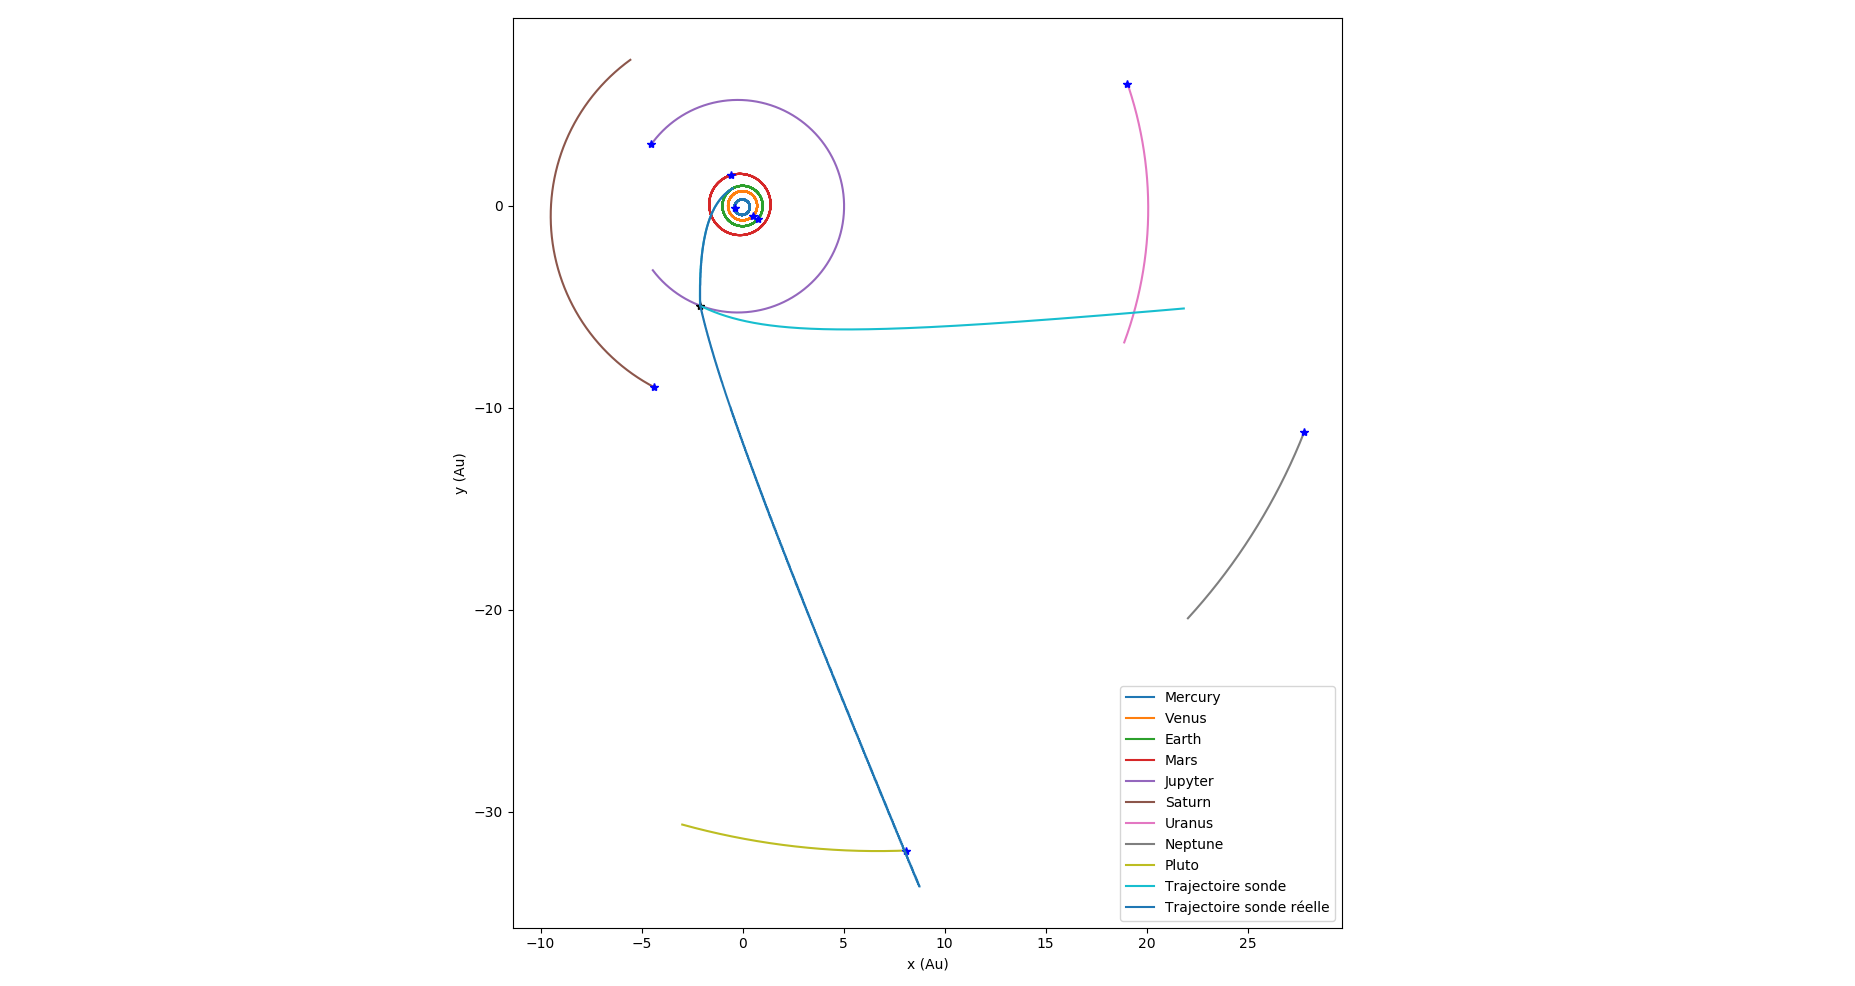

In [26]:
from IPython.display import Image
Image("figs/dt0.1.png") # dt = 0.1 jour

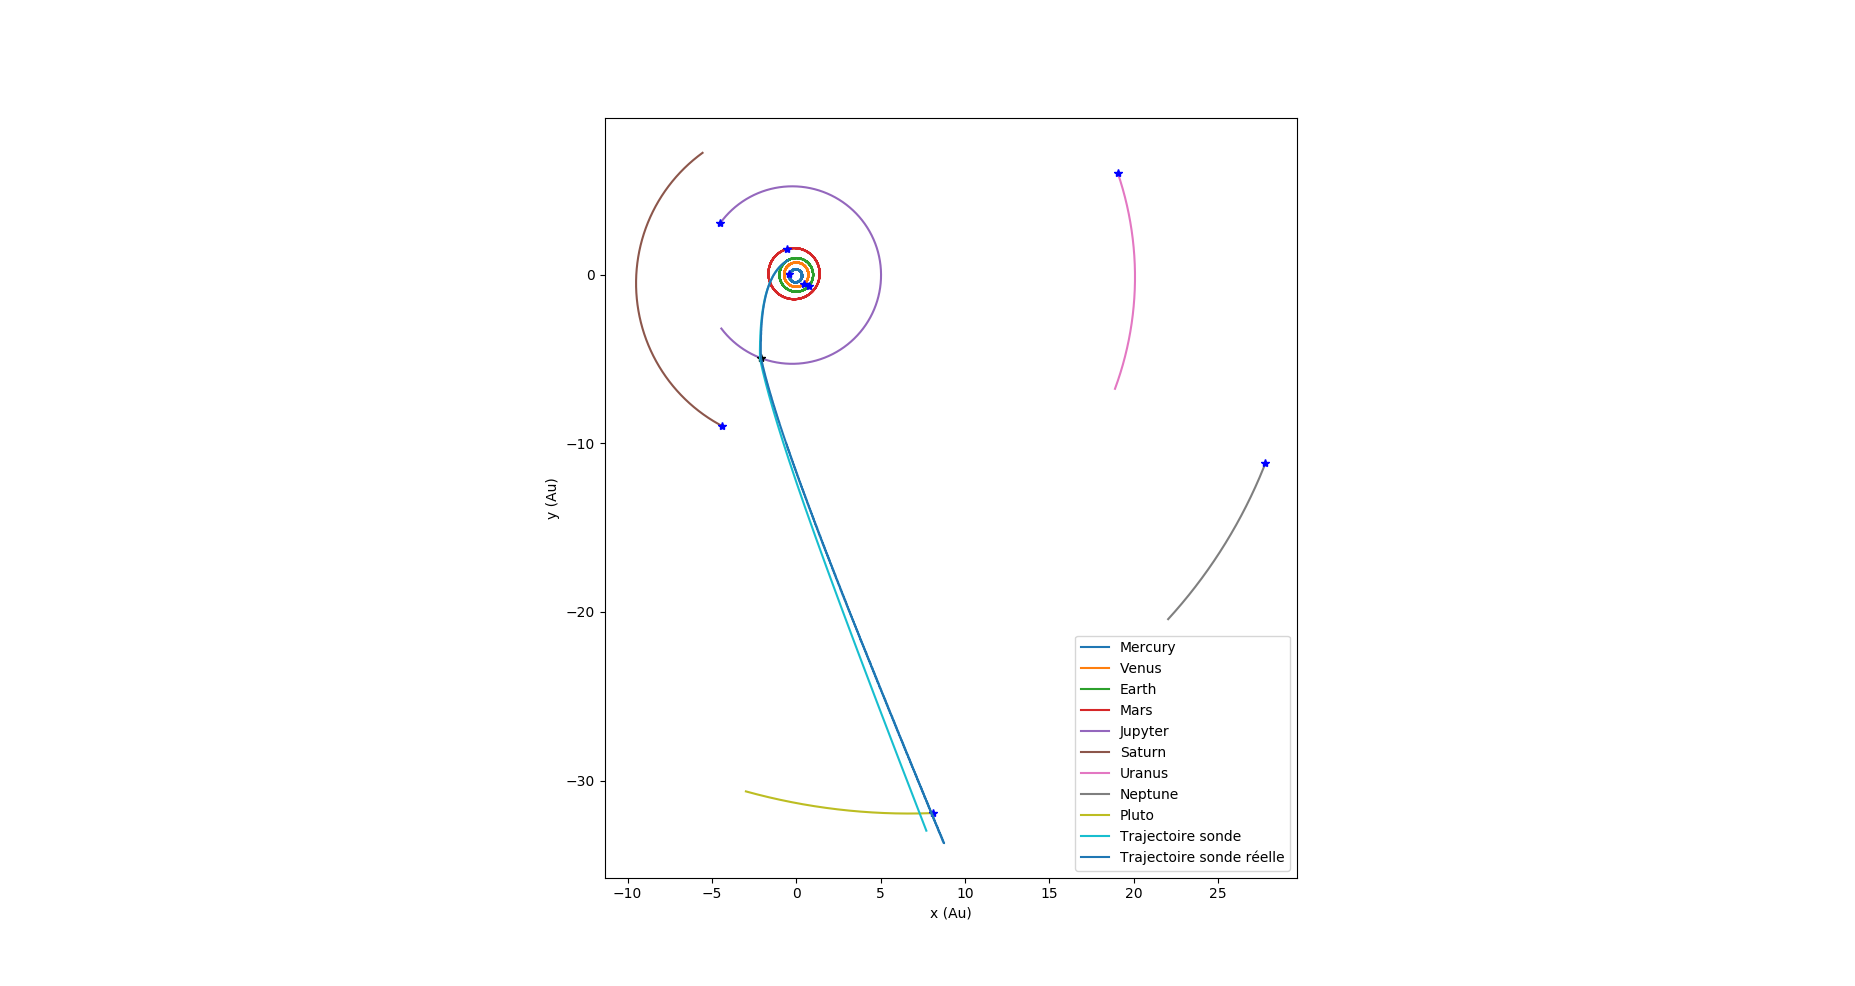

In [27]:
from IPython.display import Image
Image("figs/dt1.png") #Pour dt = 1 jour

D'après les deux essais, on voit bien que le problème est très sensible aux conditions initiales et surtout à la distance d'approche de la sonde de Jupyter, et c'est exactement le problème que NASA a eu, c'est pour ça il ont prévu des propulseurs dans la sonde, afin de corriger la trajectoire et l'approcher de la trajectoire voulue. Pour plus de détails voir ici (https://fr.wikipedia.org/wiki/New_Horizons#Propulsion). En conclusion, si Nasa décide d'envoyer des sondes interstellaires contrôlées par des humains, Elle doit être hyper-vigilante sur ce point pour que les astronautes ne finissent pas par un sénario qui ressemble à celui de la première image.


**Mise en évidence du caractère symplectique du schéma:**

Pour finir, on va essayer de tracer l'énergie mécanique massique de la sonde relative à l'énergie initiale afin de montrer que le schéma adaptatif de Verlet est bien symplectique même s'il est adaptatif.

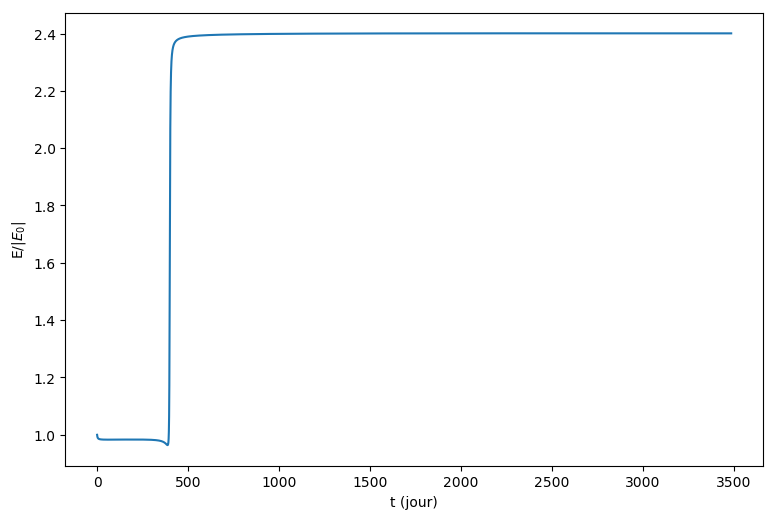

In [19]:
def Energy_obj(bodies, obj, time):

	"""
	L'Energie massique d'un objet sous l'effet d'autres objet qui lui entoure.
	"""

	N = len(bodies)

	potential = 0

	# potential = pot(bodies[0].masse, obj.x, obj.y, obj.z)

	for ip in range(N):
		potential += pot(bodies[ip].masse, obj.x-bodies[ip].x_interpol(time), obj.y-bodies[ip].y_interpol(time), obj.z-bodies[ip].z_interpol(time))
	
	return 0.5*(au**2/jour**2)*(obj.vx**2+obj.vy**2+obj.vz**2)+potential

#Definition de figure
fig=plt.figure(figsize=(9, 6), dpi= 100, facecolor='w', edgecolor='k') #To modify the size of the figure
ax = fig.add_subplot(111) #definition de l'axe


Nrg = Energy_obj(bodies, sonde, time) #Cacul de l'energie d'un objet -> Changez le numero pour voir l'energie de chaque objet;
Nrg /= np.abs(Nrg[0])  #Pour Normaliser

#Plot de l'energie
ax.plot(time, Nrg)

ax.set_xlabel("t (jour)")
ax.set_ylabel("E/$|E_0|$")

ax.get_yaxis().get_major_formatter().set_useOffset(False) #Disable scaling of values in plot wrt y-axis

plt.show()

On remarque qu'au passage de la sonde près de Jupyter, elle gagne de l'énergie grâce à l'assistance gravitationnelle avec un facteur de **2.4**. Loin de Jupyter, on voit bien que l'énergie reste conservée.

### 3.2.3 Correction Continue de La Trajectoire de New Horizons:

Afin de remédier aux erreurs de calculs produites lors de l'intégration de la trajectoire de la sonde, on va essayer de corriger la trajectoire de la sonde en modifiant d'une manière continue la valeur de la vitesse de telle façon que la trajectoire calculée soit la plus proche de la trajectoire réelle prise comme trajectoire de référence.

Pour de se faire, on prend comme critère de modification des vitesses, la condition:

$$ |\vec{r}_{calculée}-\vec{r}_{réelle}| > 0.1 au $$

Si cette condition est vérifiée, on va modifier la vitesse de la sonde à l'aide d'une propulsion:

$$ \vec{deltaV} = min(\vec{v}_{réelle} - \vec{v}_{sonde}, thrusterdeltaV) $$ 

avec **thrusterdeltaV** la valeur maximale qu'un propulseur peut donner qu'on a pris égale à **5 cm/s**, et on va montrer à partir l'implémentation ci-dessous que cette valeur maximale et suffisante pour corriger la trajectoire.

**Implémentation:** 

Il faut d'abord importer la trajectoire référence, et après il faut interpoler cette trajectoire avec les vitesses afin de pouvoir y accéder à chaque instant.

In [20]:
#Traj Horizon reelle
x, y, z, vx, vy, vz = np.genfromtxt("horizons_results.txt", usecols=(2,3,4,5,6,7), unpack=True, delimiter=",") 
plt.plot(x, y, label = "Trajectoire sonde réelle")

#Interpolation
N = len(x)

t = np.linspace(1,N,N) #Def des intervalles dt = 1
x_ = UnivariateSpline(t, x, s=0)
y_ = UnivariateSpline(t, y, s=0)
z_ = UnivariateSpline(t, z, s=0)
vx_ = UnivariateSpline(t, vx, s=0)
vy_ = UnivariateSpline(t, vy, s=0)
vz_ = UnivariateSpline(t, vz, s=0)


Maintenant, on peut implémenter la trajectoire, en appliquant des modifications sur les vitesses durant l'intégration.

In [21]:
ds = 0.0001 #step parametrique
T = 365*9+200 #(Nombre de steps)<->Periode d'integration

#Definition des tableaux 
sonde.x = np.zeros(1); sonde.x[0] = sonde.x0
sonde.y = np.zeros(1); sonde.y[0] = sonde.y0
sonde.z = np.zeros(1); sonde.z[0] = sonde.z0

sonde.vx = np.zeros(1); sonde.vx[0] = sonde.vx0 
sonde.vy = np.zeros(1); sonde.vy[0] = sonde.vy0 
sonde.vz = np.zeros(1); sonde.vz[0] = sonde.vz0

#Time array
time = np.zeros(1)


#Def des v_demi et x_demi pour l'objet
vx_demi = 0
vy_demi = 0
vz_demi = 0

x_demi = 0
y_demi = 0
z_demi = 0

#Implementation de l'integrateur de Verlet

i = 0 #count for time
j = 0 #count for number of corrections

# rho1 = rho(bodies[0].masse, sonde.x0, sonde.y0, sonde.z0, sonde.vx0, sonde.vy0, sonde.vz0)

rho1 = rho_obj(bodies, sonde, 0, time[0])

while time[i] < T:

#Define Rho 1 -> rho[i]
	if i>0:
		rho1 = rho2

#Definition des variables de milieux

	x_demi = sonde.x[i] + (ds/(2*rho1))*sonde.vx[i]
	y_demi = sonde.y[i] + (ds/(2*rho1))*sonde.vy[i]
	z_demi = sonde.z[i] + (ds/(2*rho1))*sonde.vz[i]

	fx1, fy1, fz1 = acceleration_interpol(bodies, time[i], x_demi, y_demi, z_demi)

	vx_demi = sonde.vx[i] + (ds/(2*rho1))*fx1
	vy_demi = sonde.vy[i] + (ds/(2*rho1))*fy1
	vz_demi = sonde.vz[i] + (ds/(2*rho1))*fz1

#Define Rho 2 -> rho[i+1]


	rho2 = 2*rho_obj(bodies, sonde, i, time[i]) - rho1

	deltaV_x = 0; deltaV_y = 0; deltaV_z = 0 #initialisation des propulsions

	thruster_deltaV = 2.88774164E-8 #Valeur max de deltaV fournie par un propulseur -> 5 cm/s

	if np.sqrt((sonde.x[i]-x_(time[i]))**2+(sonde.y[i]-y_(time[i]))**2+(sonde.z[i]-z_(time[i]))**2)>0.1: #Verifation de la condition:
		deltaV_x = np.min(vx_(time[i])-sonde.vx[i], thruster_deltaV) 
		deltaV_y = np.min(vy_(time[i])-sonde.vy[i], thruster_deltaV) 
		deltaV_z = np.min(vz_(time[i])-sonde.vz[i], thruster_deltaV)

		j+=1 #incrémentation de nbr de correction

	# Affectation des positions à l'indice i+1
	sonde.vx = np.append(sonde.vx , vx_demi + (ds/(2*rho2))*fx1 + deltaV_x)
	sonde.vy = np.append(sonde.vy , vy_demi + (ds/(2*rho2))*fy1 + deltaV_y)
	sonde.vz = np.append(sonde.vz , vz_demi + (ds/(2*rho2))*fz1 + deltaV_z)

	sonde.x = np.append(sonde.x , x_demi + (ds/(2*rho2))*sonde.vx[i+1])
	sonde.y = np.append(sonde.y , y_demi + (ds/(2*rho2))*sonde.vy[i+1])
	sonde.z = np.append(sonde.z , z_demi + (ds/(2*rho2))*sonde.vz[i+1])

	# Affectation de temps
	
	time = np.append(time, time[i]+((ds/2)*(1/rho1 + 1/rho2)))


#incrementation
	i = i+1

print("Nombre de corrections est :", j) #show nbr of corrections

/home/mh541/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return umr_minimum(a, axis, None, out, keepdims)


Nombre de corrections est : 3322


**Plot des trajectoires:**

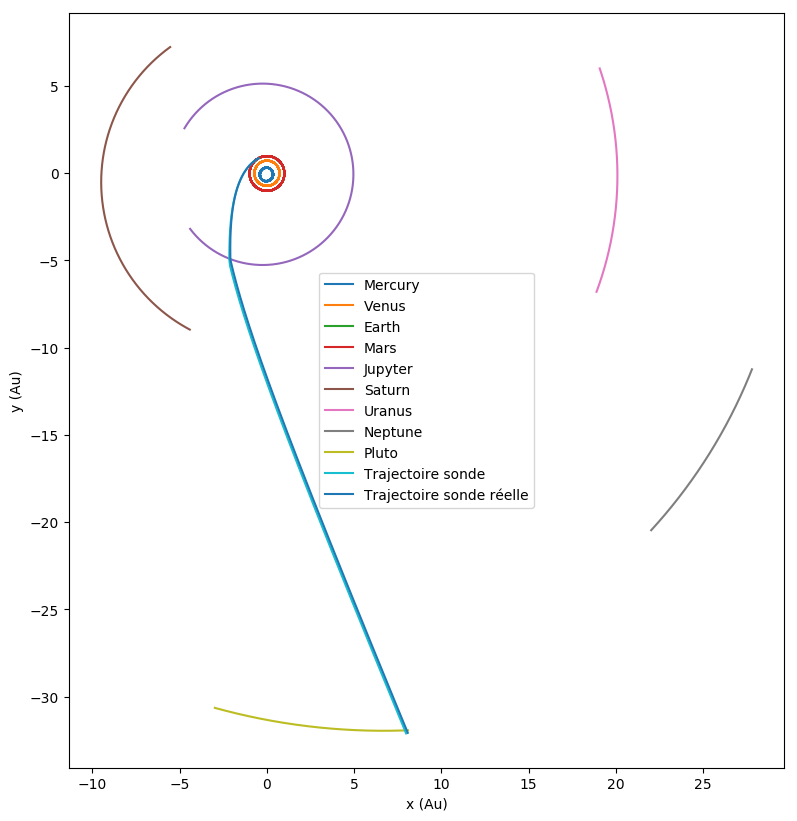

In [23]:
#Definition de figure
fig=plt.figure(figsize=(12, 10), dpi= 100, facecolor='w', edgecolor='k') #To modify the size of the figure
ax = fig.add_subplot(111) #definition de l'axe    
    
t = np.linspace(1,T,T)*dt #Def des intervalles
    
#Plot des traj interpolees
for i in range(1,Nbr_obj):	
	ax.plot(bodies[i].x_interpol(t), bodies[i].y_interpol(t), label = bodies[i].nom) 
    
#plot traj de la sonde
ax.plot(sonde.x, sonde.y, label="Trajectoire sonde")

#Plot traj reelle de la sonde (les donnees sont stockes dans horizons_results.txt)
ax.plot(x[:T], y[:T], label = "Trajectoire sonde réelle")
    
plt.gca().set_aspect('equal', adjustable='box') #equal ratios of x and y
 
ax.set_xlabel("x (Au)")    
ax.set_ylabel("y (Au)")    

plt.legend()    
plt.show()

On voit bien qu'on a réussi à corriger la trajectoire de la sonde avec des modifications continues en nombre de **3322 fois**, à l'aide de 3 propulseurs donnant une vitesse $deltaV$ suivant $x$, $y$ et $z$ dont la vitesse maximale ne dépasse pas $5 \ cm/s$ soit $18 \ mètre/heure$!!!.

# Conclusion:

Pour conclure, dans ce project, on a réussi à implémenter les trajectoires des planètes par le schéma de Verlet symplectique qui permet de conserver l'énergie mécanique de système, ensuite, on a essayé d'intégrer la trajectoire de la sonde spatiale New Horizons qui a pour but d'arriver à Pluto à l'aide d'un schéma de Verlet adaptatif et symplectique qui permet d'adapter le pas d'integration selon la valeur de l'acceleration gravitationnelle appliquée sur la sonde, mais la trajectoire obtenue commence à se dévier de la trajectoire réelle après passage par Jupyter , une raison possible qu'on a pu identifié est la sensibilité du problème aux conditions initiales des planètes qui peut influencer la trajectoire de la sonde surtout au moment où la sonde subit l'effet de fronde gravitationnelle.

Pour remédier à ce problème, on a essayé de corriger la trajectoire de la sonde d'une manière continue, afin de s'approcher le plus possible de la trajectoire désirée.

# Remerciements:

Je tiens à remercier M. Ralf Everaers pour ses conseils avisés.